In [80]:
import json
import random
import itertools
import sys
import pandas as pd
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import category_encoders

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.regularizers import l1, l2


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
def encode_time(original_dataframe: pd.DataFrame, columns_to_encode: list[str]) -> pd.DataFrame:
    new_df = pd.DataFrame()
    
    for index in range(0, len(columns_to_encode)):
        original_dataframe[columns_to_encode[index]] = original_dataframe[columns_to_encode[index]].astype('float64')
        new_df[columns_to_encode[index]] = np.sin(2 * np.pi * original_dataframe[columns_to_encode[index]] / 24.0)

    original_dataframe.update(new_df)

    return original_dataframe

def encode_utc(original_dataframe: pd.DataFrame, column_to_encode: str, pattern: str) -> pd.DataFrame:
    timestamps = []
    for i in range(len(original_dataframe)):
        time_stamp = datetime.strptime(original_dataframe.loc[i, column_to_encode], pattern)
        timestamps.append(time_stamp.timestamp())

    original_dataframe[column_to_encode] = timestamps
    return original_dataframe

def number_of_unique_values_per_column(dataframe: pd.DataFrame) -> None:
    print([(column, dataframe[column].nunique()) for column in dataframe.columns])

def onehot_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    encoder = OneHotEncoder()
    encoded_column = encoder.fit_transform(original_dataframe[[column_to_encode]])
    encoded_column_dataframe = pd.DataFrame(encoded_column.toarray(), columns=encoder.get_feature_names_out([column_to_encode]))
    original_dataframe = pd.concat([original_dataframe, encoded_column_dataframe], axis=1)
    original_dataframe = original_dataframe.drop(columns=['device_id'])
    return original_dataframe

def encode_classification(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    label_encoder = LabelEncoder()
    original_dataframe[column_to_encode] = label_encoder.fit_transform(original_dataframe[column_to_encode])
    return original_dataframe

def encode_boolean(original_dataframe: pd.DataFrame, columns_to_encode: list[str]) -> pd.DataFrame:
    for index in range(0, len(columns_to_encode)):
        original_dataframe[columns_to_encode[index]] = original_dataframe[columns_to_encode[index]].astype('int')
    return original_dataframe


def move_column_to_the_front(original_dataframe: pd.DataFrame, column_to_move: str) -> pd.DataFrame:
    first_column = original_dataframe.pop(column_to_move)
    original_dataframe.insert(0, column_to_move, first_column)
    return original_dataframe


In [46]:
# read json data
with open("datasets\\transfer\\smaller_dataset.json") as file:
    parsed_json = json.load(file)


# build dataframe 
total_amount_of_rows = 0
all_sessions = pd.DataFrame()
for i in pd.json_normalize(parsed_json['traces']):
    total_amount_of_rows += len(pd.json_normalize(parsed_json['traces'][i]))
    single_session = pd.json_normalize(parsed_json['traces'][i])
    all_sessions = pd.concat([all_sessions, single_session], ignore_index=True)

# include and encode one by one and test again, also add classification-1 and classification-2 as input feature
all_sessions = all_sessions.drop(columns=['device_class', 'content_portal', 'weather_day_id', 'device_platform', 'weather_hour_id'])
all_sessions = all_sessions.drop(columns=['device_height_px', 'oha_language_iso2', 'device_orientation', 'device_country_iso2', 'device_language_iso2'])
all_sessions = all_sessions.drop(columns=['weather_future_day_id', 'weather_future_hour_id'])

# encode columns
all_sessions = encode_time(all_sessions, ['time_hod'])
all_sessions = encode_utc(all_sessions, 'time_utc', "%Y-%m-%dT%H:%M:%S.%fZ")
all_sessions = encode_utc(all_sessions, 'time_local', "%Y-%m-%dT%H:%M:%S.%f")
all_sessions = onehot_encode_column(all_sessions, 'device_id')
all_sessions = encode_classification(all_sessions, 'content_id')
all_sessions = encode_boolean(all_sessions, ['device_online'])

all_sessions = move_column_to_the_front(all_sessions, 'content_id')
all_sessions = move_column_to_the_front(all_sessions, 'event_type')
all_sessions = move_column_to_the_front(all_sessions, 'oha_layout')
all_sessions = move_column_to_the_front(all_sessions, 'device_online')
all_sessions = move_column_to_the_front(all_sessions, 'device_width_px')
all_sessions = move_column_to_the_front(all_sessions, 'session_id')

# build features vectors
feature_vectors = []
for i in range(0, len(all_sessions)):
    if(i < len(all_sessions) - 1):
        if all_sessions.iloc[i]['session_id'] == all_sessions.iloc[i+1]['session_id']:
            feature_vector = (all_sessions.iloc[i], all_sessions.iloc[i+1]['content_id']) 
            feature_vectors.append(feature_vector)
        else: 
            feature_vector = (all_sessions.iloc[i], 39) 
            feature_vectors.append(feature_vector)

# shuffle dataset
random.shuffle(feature_vectors)

# build dict to encode session_ids
unique_session_ids = all_sessions['session_id'].unique()
session_ids_to_label = dict()
session_id_value = 0
for session_id in unique_session_ids:
    if session_id not in session_ids_to_label:
        session_ids_to_label[session_id] = session_id_value
        session_id_value += 1

# encode session_id
for index, (series, _) in enumerate(feature_vectors):
    series.loc['session_id'] = session_ids_to_label[series.loc['session_id']]


# build train / test sets
input_features = []
classification_labels = []

for input_feature, classification in feature_vectors:
    input_feature_to_list = series.tolist()
    input_features.append(input_feature_to_list)
    classification_labels.append(classification)

X_train, X_test, y_train, y_test = train_test_split(input_features, classification_labels, test_size=0.2, random_state=42)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

#print("X_train[0]: ", X_train[0])
#print(all_sessions.iloc[0])

In [47]:
print(X_train.shape)

X_train_session_id, X_train = X_train[:, :1], X_train[:, 1:]
X_train_device_width_px, X_train = X_train[:, :1], X_train[:, 1:]
X_train_device_online, X_train = X_train[:, :1], X_train[:, 1:]
X_train_oha_layout, X_train = X_train[:, :1], X_train[:, 1:]
X_train_device_event_type, X_train = X_train[:, :1], X_train[:, 1:]
X_train_device_content_id, X_train = X_train[:, :1], X_train[:, 1:]

print(X_train.shape)

X_test_session_id, X_test = X_test[:, :1], X_test[:, 1:]
X_test_device_width_px, X_test = X_test[:, :1], X_test[:, 1:]
X_test_device_online, X_test = X_test[:, :1], X_test[:, 1:]
X_test_oha_layout, X_test = X_test[:, :1], X_test[:, 1:]
X_test_device_event_type, X_test = X_test[:, :1], X_test[:, 1:]
X_test_device_content_id, X_test = X_test[:, :1], X_test[:, 1:]

#print([(column, all_sessions[column].nunique()) for column in all_sessions.columns])


(212, 39)
(212, 33)


In [78]:
def model_builder(hp):
    embedding_input_session_id = tf.keras.layers.Input(shape=(1,), dtype='int32') 
    embedding_lyer_session_id = tf.keras.layers.Embedding(input_dim=81, output_dim=9)(embedding_input_session_id)
    flattened_session_id = tf.keras.layers.Flatten()(embedding_lyer_session_id)

    embedding_input_device_with_px = tf.keras.layers.Input(shape=(1,), dtype='int32')
    embedding_layer_device_with_px = tf.keras.layers.Embedding(input_dim=15, output_dim=4)(embedding_input_device_with_px)
    flattened_device_with_px = tf.keras.layers.Flatten()(embedding_layer_device_with_px)

    embedding_input_device_online = tf.keras.layers.Input(shape=(1,), dtype='int32')
    embedding_layer_device_online = tf.keras.layers.Embedding(input_dim=2, output_dim=2)(embedding_input_device_online)
    flattened_device_online = tf.keras.layers.Flatten()(embedding_layer_device_online)

    embedding_input_oha_layout = tf.keras.layers.Input(shape=(1,), dtype='int32')
    embedding_layer_oha_layout = tf.keras.layers.Embedding(input_dim=3, output_dim=2)(embedding_input_oha_layout)
    flattened_oha_layout = tf.keras.layers.Flatten()(embedding_layer_oha_layout)

    embedding_input_event_type = tf.keras.layers.Input(shape=(1,), dtype='int32')
    embedding_layer_event_type = tf.keras.layers.Embedding(input_dim=6, output_dim=3)(embedding_input_event_type)
    flattened_oha_event_type = tf.keras.layers.Flatten()(embedding_layer_event_type)

    embedding_input_content_id = tf.keras.layers.Input(shape=(1,), dtype='int32')
    embedding_layer_content_id = tf.keras.layers.Embedding(input_dim=39, output_dim=7)(embedding_input_content_id)
    flattened_oha_content_id = tf.keras.layers.Flatten()(embedding_layer_content_id)
# -------------------------------------
    concatenated_embeddings = tf.keras.layers.Concatenate()([flattened_session_id, flattened_device_with_px, flattened_device_online, flattened_oha_layout, flattened_oha_event_type, flattened_oha_content_id])

    flattened_input = tf.keras.layers.Input(shape=(X_train.shape[1],))
    flattened = tf.keras.layers.Flatten()(flattened_input)

    hp_units = hp.Int('units', min_value=16, max_value=512, step=32)
    hp_layers = hp.Int('layers', min_value=2, max_value=7, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    concatenated = tf.keras.layers.Concatenate()([concatenated_embeddings, flattened])
    #concatenated = tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_regularizer=l1(hp.Float('l1', min_value=1e-4, max_value=1e-2, sampling='LOG')))(concatenated)
    concatenated = tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_regularizer=l2(hp.Float('l2', min_value=1e-4, max_value=1e-2, sampling='LOG')))(concatenated)
    #concatenated = tf.keras.layers.BatchNormalization()(concatenated)

    for _ in range(hp_layers):
        concatenated = tf.keras.layers.Dense(units=hp_units, activation='relu')(concatenated)

    output = tf.keras.layers.Dense(40)(concatenated)
# -------------------------------------
    model = tf.keras.models.Model(inputs=[embedding_input_session_id, embedding_input_device_with_px, embedding_input_device_online, embedding_input_oha_layout, embedding_input_event_type, embedding_input_content_id, flattened_input], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     directory='trained_models',
                     project_name='testing_l2')

# -------------------------------------
tuner.search([X_train_session_id, X_train_device_width_px, X_train_device_online, X_train_oha_layout, X_train_device_event_type, X_train_device_content_id, X_train], y_train, epochs=50, validation_split=0.2)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)

# -------------------------------------
history = model.fit([X_train_session_id, X_train_device_width_px, X_train_device_online, X_train_oha_layout, X_train_device_event_type, X_train_device_content_id, X_train], y_train, epochs=50, batch_size=32, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# -------------------------------------
eval_result = model.evaluate([X_test_session_id, X_test_device_width_px, X_test_device_online, X_test_device_event_type, X_test_device_content_id, X_test_oha_layout, X_test], y_test)
print("[test loss, test accuracy]:", eval_result)

print(f"Best number of units in the first dense layer: {best_hps.get('units')}")
print(f"Best number of layers: {best_hps.get('layers')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Reloading Tuner from trained_models\testing_l2\tuner0.json
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.0966 - loss: 4.2952 - val_accuracy: 0.3256 - val_loss: 143250528.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2259 - loss: 3.0425 - val_accuracy: 0.3256 - val_loss: 47473908.0000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2193 - loss: 2.9482 - val_accuracy: 0.3256 - val_loss: 123322936.0000
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2015 - loss: 2.9298 - val_accuracy: 0.3256 - val_loss: 136973904.0000
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2885 - loss: 2.9185 - val_accuracy: 0.1163 - val_loss: 33964540.0000
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1553 - loss: 3.1407 - val_accuracy: 0.3256 - val_loss: 26380890.0000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2451 - loss: 2.6719 - val_accuracy: 0.1163 - val_loss: 41627784.0000
Epoch 8/50
6/6

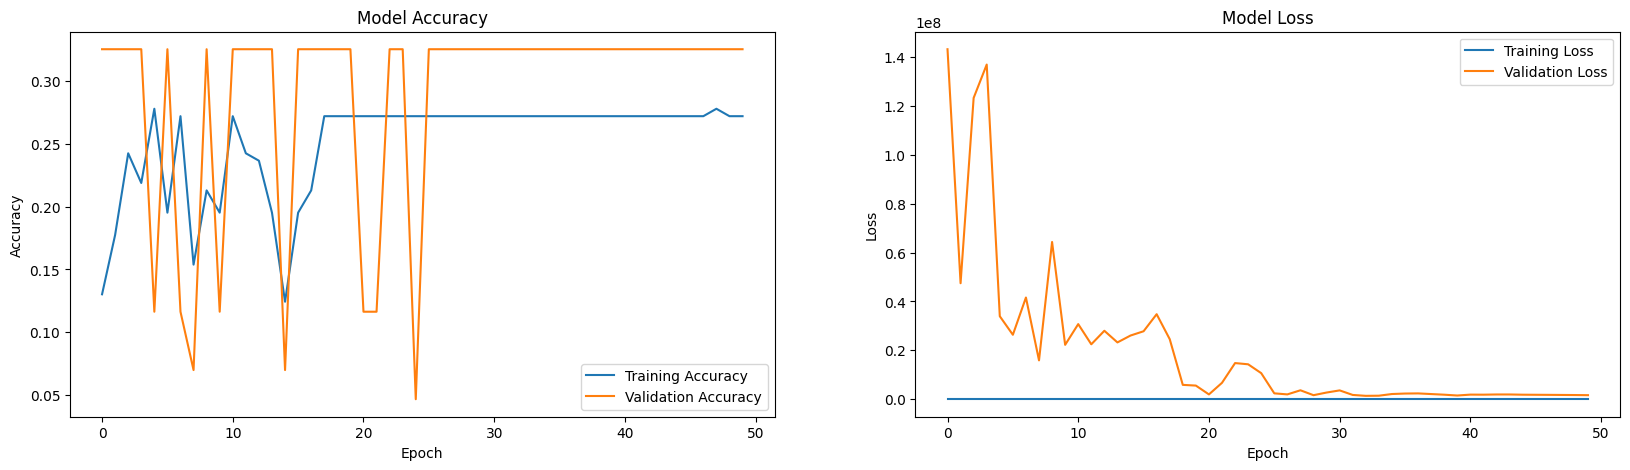

val_accuracy:  [0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.11627907305955887, 0.3255814015865326, 0.11627907305955887, 0.06976744532585144, 0.3255814015865326, 0.11627907305955887, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.06976744532585144, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.11627907305955887, 0.11627907305955887, 0.3255814015865326, 0.3255814015865326, 0.04651162773370743, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.3255814015865326, 0.32558140158653

In [82]:
import matplotlib.pyplot as plt

def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')

    plt.show()

plot_history(history)
print("val_accuracy: ", history.history['val_accuracy'])
print("accuracy: ", history.history['accuracy'])
print("val_loss: ", history.history['val_loss'])
print("loss: ", history.history['loss'])
